In [75]:
import os
import sys

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data

sys.path.append("..")

from src.gnn import MixHopNet
from src.load_data import load_data
from src.sheaf import CSNN
from src.utils import accuracy, f1_macro

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
if not os.path.exists("../images"):
    os.makedirs("../images")

## Load dataset


In [77]:
DATASET_NAME = "texas"  # ['texas', 'cornell', 'wisconsin']
SPLIT = [0.7, 0.2, 0.1]  # Train, Val, Test split ratios

In [78]:
torch.manual_seed(42)
data: Data
data, train_mask, val_mask, test_mask, num_classes, class_weights = load_data(
    DATASET_NAME, SPLIT
)

Texas | num_nodes=183 | num_classes=5
Train=126, val=35, test=22
class_counts: [23.0, 0.0, 12.0, 70.0, 21.0]
mask_kept_classes: [True, False, True, True, True]
class_weights: [0.9215579032897949, 0.0, 1.7663191556930542, 0.3027975857257843, 1.0093252658843994]


c:\Users\Gomi\OneDrive - Universidad Pontificia Comillas\5ºIMAT\Geometria de la Informacion\Sheaf-NN\.venv\lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

## Sheaf-NN


In [ ]:
torch.manual_seed(42)
# Modelo CORNELL AND WISCONSIN
# model = CSNN(
#     in_dim=data.x.size(-1),
#     hidden_dim=64,
#     out_dim=num_classes,
#     num_nodes=data.num_nodes,
#     edge_index=data.edge_index,
#     num_layers=2,
#     dropout=0.6,
# ).to(device)
# Modelo CSNN TEXAS
model = CSNN(
    in_dim=data.x.size(-1),
    hidden_dim=48,
    out_dim=num_classes,
    num_nodes=data.num_nodes,
    edge_index=data.edge_index,
    num_layers=1,
    dropout=0.8,
).to(device)

### Training


In [114]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4,
)
criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=100, min_lr=1e-5
)

In [115]:
# Históricos para plotting
train_acc_hist, val_acc_hist, test_acc_hist = [], [], []
train_f1_hist, val_f1_hist, test_f1_hist = [], [], []

# Entrenamiento con early stopping
best_val_acc = 0.0
best_state = None
max_epochs = 200

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        out = model(data.x)

        # Accuracies
        train_acc = accuracy(out[train_mask], data.y[train_mask])
        val_acc = accuracy(out[val_mask], data.y[val_mask])
        test_acc = accuracy(out[test_mask], data.y[test_mask])

        # F1 macro
        train_f1 = f1_macro(
            out[train_mask], data.y[train_mask], num_classes=num_classes
        )
        val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
        test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

    # Guardar históricos
    train_acc_hist.append(float(train_acc))
    val_acc_hist.append(float(val_acc))
    test_acc_hist.append(float(test_acc))

    train_f1_hist.append(train_f1)
    val_f1_hist.append(val_f1)
    test_f1_hist.append(test_f1)

    # Early stopping basado en validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % (max_epochs // 20) == 0 or epoch == 1:
        print(
            f"Epoch {epoch:04d} | "
            f"loss {loss.item():.4f} | "
            f"train acc {train_acc:.4f} | "
            f"val acc {val_acc:.4f} | "
            f"test acc {test_acc:.4f} | "
            # f"train f1 {train_f1:.4f} | "
            # f"val f1 {val_f1:.4f} | "
            # f"test f1 {test_f1:.4f}"
        )

    lr_scheduler.step(val_acc)

# Cargar mejor modelo
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

model.eval()
with torch.no_grad():
    out = model(data.x)
    final_train_acc = accuracy(out[train_mask], data.y[train_mask])
    final_val_acc = accuracy(out[val_mask], data.y[val_mask])
    final_test_acc = accuracy(out[test_mask], data.y[test_mask])

    final_train_f1 = f1_macro(
        out[train_mask], data.y[train_mask], num_classes=num_classes
    )
    final_val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
    final_test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

print(
    f"Final | "
    f"train acc {final_train_acc:.4f} | val acc {final_val_acc:.4f} | test acc {final_test_acc:.4f} | "
    # f"train f1 {final_train_f1:.4f} | val f1 {final_val_f1:.4f} | test f1 {final_test_f1:.4f}"
)


Epoch 0001 | loss 1.5818 | train acc 0.1667 | val acc 0.1714 | test acc 0.1364 | 
Epoch 0010 | loss 1.4827 | train acc 0.7063 | val acc 0.7429 | test acc 0.5909 | 
Epoch 0020 | loss 1.4561 | train acc 0.6111 | val acc 0.5714 | test acc 0.4091 | 
Epoch 0030 | loss 1.4080 | train acc 0.2619 | val acc 0.1714 | test acc 0.1818 | 
Epoch 0040 | loss 1.3043 | train acc 0.8651 | val acc 0.7429 | test acc 0.6818 | 
Epoch 0050 | loss 1.1825 | train acc 0.9603 | val acc 0.8000 | test acc 0.6818 | 
Epoch 0060 | loss 0.8988 | train acc 0.9524 | val acc 0.8286 | test acc 0.8182 | 
Epoch 0070 | loss 0.7362 | train acc 0.9921 | val acc 0.8571 | test acc 0.7727 | 
Epoch 0080 | loss 0.6431 | train acc 0.9921 | val acc 0.8286 | test acc 0.8182 | 
Epoch 0090 | loss 0.4980 | train acc 1.0000 | val acc 0.8857 | test acc 0.7727 | 
Epoch 0100 | loss 0.5775 | train acc 1.0000 | val acc 0.9714 | test acc 0.8636 | 
Epoch 0110 | loss 0.4020 | train acc 1.0000 | val acc 0.9429 | test acc 0.7273 | 
Epoch 0120 | los

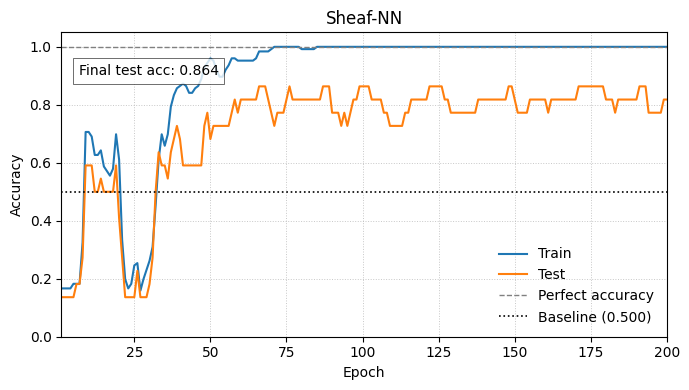

In [116]:
# Baseline accuracy
most_common_class_count = (
    torch.unique(data.y[test_mask], return_counts=True)[1].max().item()
)
baseline_accuracy = most_common_class_count / test_mask.sum().item()

epochs = range(1, max_epochs + 1)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(epochs, train_acc_hist, label="Train", linewidth=1.5)
ax.plot(epochs, test_acc_hist, label="Test", linewidth=1.5)

ax.axhline(1.0, color="grey", linestyle="--", linewidth=1, label="Perfect accuracy")
ax.axhline(
    baseline_accuracy,
    color="black",
    linestyle=":",
    linewidth=1.2,
    label=f"Baseline ({baseline_accuracy:.3f})",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Sheaf-NN")
ax.set_ylim(0, 1.05)
ax.set_xlim(1, max_epochs)
ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
ax.legend(frameon=False)

# Text box for final test accuracy
ax.text(
    0.26,
    0.85,
    f"Final test acc: {final_test_acc:.3f}",
    ha="right",
    va="bottom",
    transform=ax.transAxes,
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", linewidth=0.5, alpha=0.8),
)

plt.tight_layout()
plt.show()

fig.savefig(f"../images/comparative_sheaf_{DATASET_NAME}.png", dpi=300)


## GNN


In [125]:
model = MixHopNet(
    in_dim=data.x.size(-1),
    hidden_dim=64,
    out_dim=num_classes,
    dropout=0.8,
    powers=(0, 1, 2, 3),
).to(device)

### Training


In [126]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4,
)
criterion = nn.CrossEntropyLoss(weight=class_weights)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=100, min_lr=1e-5
)

In [127]:
# Históricos para plotting
train_acc_hist, val_acc_hist, test_acc_hist = [], [], []
train_f1_hist, val_f1_hist, test_f1_hist = [], [], []

# Entrenamiento con early stopping
best_val_acc = 0.0
best_state = None
max_epochs = 300

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)

        # Accuracies
        train_acc = accuracy(out[train_mask], data.y[train_mask])
        val_acc = accuracy(out[val_mask], data.y[val_mask])
        test_acc = accuracy(out[test_mask], data.y[test_mask])

        # F1 macro
        train_f1 = f1_macro(
            out[train_mask], data.y[train_mask], num_classes=num_classes
        )
        val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
        test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

    # Guardar históricos
    train_acc_hist.append(float(train_acc))
    val_acc_hist.append(float(val_acc))
    test_acc_hist.append(float(test_acc))

    train_f1_hist.append(train_f1)
    val_f1_hist.append(val_f1)
    test_f1_hist.append(test_f1)

    # Early stopping basado en validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % (max_epochs // 20) == 0 or epoch == 1:
        print(
            f"Epoch {epoch:04d} | "
            f"loss {loss.item():.4f} | "
            f"train acc {train_acc:.4f} | "
            f"val acc {val_acc:.4f} | "
            f"test acc {test_acc:.4f} | "
            # f"train f1 {train_f1:.4f} | "
            # f"val f1 {val_f1:.4f} | "
            # f"test f1 {test_f1:.4f}"
        )

    lr_scheduler.step(val_acc)

# Cargar mejor modelo
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    final_train_acc = accuracy(out[train_mask], data.y[train_mask])
    final_val_acc = accuracy(out[val_mask], data.y[val_mask])
    final_test_acc = accuracy(out[test_mask], data.y[test_mask])

    final_train_f1 = f1_macro(
        out[train_mask], data.y[train_mask], num_classes=num_classes
    )
    final_val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
    final_test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

print(
    f"Final | "
    f"train acc {final_train_acc:.4f} | val acc {final_val_acc:.4f} | test acc {final_test_acc:.4f} | "
    # f"train f1 {final_train_f1:.4f} | val f1 {final_val_f1:.4f} | test f1 {final_test_f1:.4f}"
)


Epoch 0001 | loss 1.5934 | train acc 0.4762 | val acc 0.5714 | test acc 0.4091 | 
Epoch 0015 | loss 1.3618 | train acc 0.1984 | val acc 0.2000 | test acc 0.2727 | 
Epoch 0030 | loss 1.2977 | train acc 0.5556 | val acc 0.6286 | test acc 0.5455 | 
Epoch 0045 | loss 1.2305 | train acc 0.2619 | val acc 0.3143 | test acc 0.3182 | 
Epoch 0060 | loss 1.0046 | train acc 0.7698 | val acc 0.7143 | test acc 0.6364 | 
Epoch 0075 | loss 0.8589 | train acc 0.8730 | val acc 0.7429 | test acc 0.5909 | 
Epoch 0090 | loss 0.7645 | train acc 0.9444 | val acc 0.7143 | test acc 0.7727 | 
Epoch 0105 | loss 0.6682 | train acc 1.0000 | val acc 0.7429 | test acc 0.7727 | 
Epoch 0120 | loss 0.6319 | train acc 0.9921 | val acc 0.7143 | test acc 0.7727 | 
Epoch 0135 | loss 0.5625 | train acc 1.0000 | val acc 0.7714 | test acc 0.8182 | 
Epoch 0150 | loss 0.5059 | train acc 1.0000 | val acc 0.7714 | test acc 0.7727 | 
Epoch 0165 | loss 0.5223 | train acc 0.9921 | val acc 0.8000 | test acc 0.7727 | 
Epoch 0180 | los

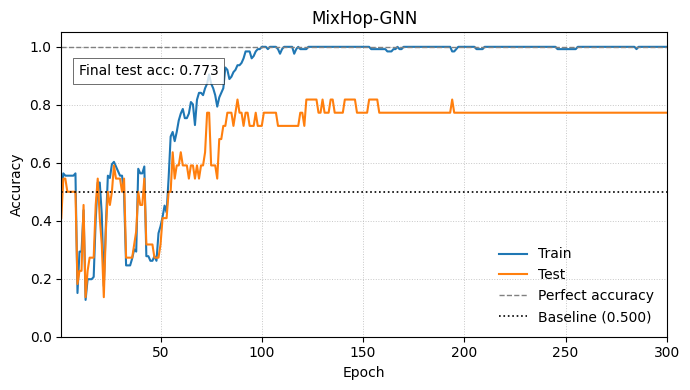

In [128]:
# Baseline accuracy
most_common_class_count = (
    torch.unique(data.y[test_mask], return_counts=True)[1].max().item()
)
baseline_accuracy = most_common_class_count / test_mask.sum().item()

epochs = range(1, max_epochs + 1)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(epochs, train_acc_hist, label="Train", linewidth=1.5)
ax.plot(epochs, test_acc_hist, label="Test", linewidth=1.5)

ax.axhline(1.0, color="grey", linestyle="--", linewidth=1, label="Perfect accuracy")
ax.axhline(
    baseline_accuracy,
    color="black",
    linestyle=":",
    linewidth=1.2,
    label=f"Baseline ({baseline_accuracy:.3f})",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("MixHop-GNN")
ax.set_ylim(0, 1.05)
ax.set_xlim(1, max_epochs)
ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
ax.legend(frameon=False)

# Text box for final test accuracy
ax.text(
    0.26,
    0.85,
    f"Final test acc: {final_test_acc:.3f}",
    ha="right",
    va="bottom",
    transform=ax.transAxes,
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", linewidth=0.5, alpha=0.8),
)

plt.tight_layout()
plt.show()

fig.savefig(f"../images/comparative_gnn_{DATASET_NAME}.png", dpi=300)
